# 주요 라이브러리 버전을 확인

In [1]:
!pip install summa

In [2]:
from importlib.metadata import version
import nltk
import tensorflow
import summa
import pandas as pd
import nltk
nltk.download('stopwords')
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='bs4')
print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


3.6.5
2.6.0
1.3.3
1.2.0


# Step 1. 데이터 수집하기

In [3]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


In [4]:
data.sample(10)

,headlines,text
83187,"Netherlands let 300 Muslims die in Srebrenica,...",The Netherlands is partially responsible for t...
61985,IndiGo blames staffer who shot video for manha...,"In a report to the Civil Aviation Ministry, In..."
35194,Man reunited with family after 40 years due to...,A YouTube video has helped an Imphal-based fam...
56122,I&B ministry approves merger of Dish TV and Vi...,Zee group-owned DTH operator Dish TV on Friday...
13667,Jack Ma plans institute for tech entrepreneurs...,"Jack Ma, the Co-founder of Chinese e-commerce ..."
48626,"Sehwag hits 62, Afridi 0 in cricket match play...",Virender Sehwag's 62(31) went in vain as Shahi...
42585,How did firm accused in FB data scandal influe...,"British data firm Cambridge Analytica, accused..."
82524,"US banned Modi earlier, now gave grand welcome...",Hizbul Mujahideen chief Syed Salahuddin slamme...
67519,China opens highway in Tibet near Arunachal Pr...,China on Saturday opened a new 409 km-long exp...
62,Vatican priest handling sex abuse cases quits ...,A senior priest at the Vatican who handled cas...


# Step 2. 데이터 전처리하기 (추상적 요약)
#### 실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('text 전체 샘플수 :', (len(data)))
data.drop_duplicates(subset = ['headlines'], inplace=True)
print('headlines 전체 샘플수 :', (len(data)))

text 전체 샘플수 : 98360
headlines 전체 샘플수 : 98262


In [7]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [8]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


### 텍스트 정규화와 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수 - 추상적 요약(정규화, 불필요한 정보 제거)
def preprocess_sentence(sentence, remove_stopwords=True):
    if sentence is None:  # None 값 처리
        return ''
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    return sentence  # 전처리된 문장을 반환

# 본문(text)에 대해서는 불용어 제거 적용
data['text'] = data['text'].apply(lambda x: preprocess_sentence(x, remove_stopwords=True))

# 요약(headlines)에 대해서는 불용어 제거 미적용
data['headlines'] = data['headlines'].apply(lambda x: preprocess_sentence(x, remove_stopwords=False))

# 데이터 전처리 결과 확인
data.head()


,headlines,text
0,upgrad learner switches to career in ml al w...,saurav kant an alumnus of upgrad and iiit b p...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform ...
2,new zealand end rohit sharma led india matc...,new zealand defeated india by wickets in the...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customer...
4,have known hirani for yrs what if metoo claim...,speaking about the sexual harassment allegatio...


In [12]:
clean_text = []

for text in data['text']:
    processed_text = preprocess_sentence(text)
    clean_text.append(processed_text)


# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant  an alumnus of upgrad and iiit b pg program in machine learning and artificial intelligence  was a sr systems engineer at infosys with almost   years of work experience  the program and upgrad     degree career support helped him transition to a data scientist at tech mahindra with     salary hike  upgrad online power learning has powered   lakh  careers ', 'kunal shah credit card bill payment platform  cred  gave users a chance to win free food from swiggy for one year  pranav kaushik  a delhi techie  bagged this reward after spending      cred coins  users get one cred coin per rupee of bill paid  which can be used to avail rewards from brands like ixigo  bookmyshow  ubereats  cult fit and more ', 'new zealand defeated india by   wickets in the fourth odi at hamilton on thursday to win their first match of the five match odi series  india lost an international match under rohit sharma captaincy after    consecutive victories dating back to march       th

In [13]:
clean_headlines = []

for headlines in data['headlines']:
    processed_headlines = preprocess_sentence(headlines)
    clean_headlines.append(processed_headlines)


# 전처리 후 출력
print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['upgrad learner switches to career in ml   al with     salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india    match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs  what if metoo claims are not true  sonam']


In [14]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [15]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [16]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98262


### Train, Test 데이터 나누기 - 샘플의 최대 길이 정하기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 71
텍스트의 평균 길이 : 57.92975921515947
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 17
헤드라인의 평균 길이 : 9.48376788585618


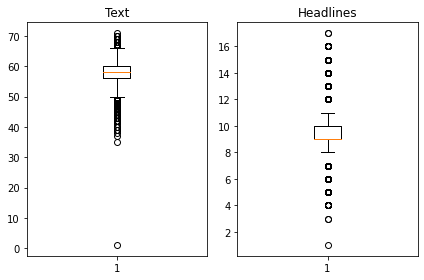

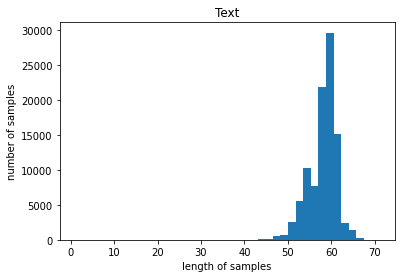

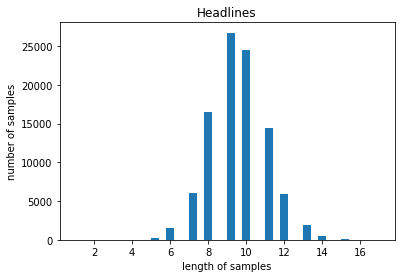

In [17]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
text_max_len = 60
headlines_max_len = 15

In [19]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [20]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.8045124259632411
전체 샘플 중 길이가 15 이하인 샘플의 비율: 0.9998066393926441


In [21]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 79043


#### 시작 토큰과 종료 토큰 추가하기

In [22]:
# 제목 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al w...,saurav kant an alumnus of upgrad and iiit b p...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al w...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform ...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india matc...,new zealand defeated india by wickets in the...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india matc...
3,aegon life iterm insurance plan helps customer...,with aegon life iterm insurance plan customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan has deni...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...


In [23]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 8220 28246 71885 ... 71198 32743 52828]


In [25]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [26]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 15808


In [27]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 63235
훈련 레이블의 개수 : 63235
테스트 데이터의 개수 : 15808
테스트 레이블의 개수 : 15808


### 단어 집합(vocabulary) 만들기 및 정수 인코딩

In [28]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [29]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 63870
등장 빈도가 6번 이하인 희귀 단어의 수: 43805
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20065
단어 집합에서 희귀 단어의 비율: 68.58462501957099
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.4641623563066872


In [30]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [31]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4, 161, 34, 66, 360, 685, 4458, 8, 851, 951, 7, 249, 191, 1, 1688, 10, 1, 514, 13, 4, 561, 4914, 107, 15, 4, 2562, 4115, 2903, 1482, 6, 1, 514, 4458, 38, 1342, 4, 2458, 3925, 30, 542, 1, 1594, 16, 8, 3500, 2, 153, 16, 12, 947, 3], [74, 1063, 4147, 5875, 3079, 137, 721, 3, 1, 4577, 1185, 5, 1, 479, 6, 500, 9, 1004, 1237, 1803, 3, 1, 6, 7520, 2172, 675, 1134, 8, 500, 83, 6184, 309, 9, 374, 1, 1359, 2845, 108, 6, 33, 1039, 14, 3096, 3, 429, 19, 570, 500, 9, 122, 137, 721, 3, 1, 479], [159, 1024, 1483, 620, 4008, 14, 12, 1, 1273, 182, 3056, 17, 1, 759, 7799, 355, 39, 34, 775, 5237, 3056, 14, 2281, 2563, 1, 427, 47, 14, 5114, 7389, 324, 149, 419, 6727, 3056, 17, 324, 259, 6, 4008, 14, 324, 654]]


In [32]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [33]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27763
등장 빈도가 5번 이하인 희귀 단어의 수: 18551
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9212
단어 집합에서 희귀 단어의 비율: 66.81914778662248
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.3995080959838


In [34]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 44, 41, 269, 402, 400, 574], [1, 316, 467, 58, 1252, 1575, 5, 1764, 49, 54, 399], [1, 413, 1603, 113, 1019], [1, 22, 36, 840, 20, 1393, 78, 223], [1, 49, 11, 55]]
target
decoder  [[44, 41, 269, 402, 400, 574, 2], [316, 467, 58, 1252, 1575, 5, 1764, 49, 54, 399, 2], [413, 1603, 113, 1019, 2], [22, 36, 840, 20, 1393, 78, 223, 2], [49, 11, 55, 2]]


In [35]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 11
삭제할 테스트 데이터의 개수 : 3
훈련 데이터의 개수 : 63224
훈련 레이블의 개수 : 63224
테스트 데이터의 개수 : 15805
테스트 레이블의 개수 : 15805


### 패딩하기

In [36]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기

In [37]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

In [38]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [39]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [40]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      1024000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 모델 훈련하기

In [41]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
247/247 [==============================] - 33s 107ms/step - loss: 3.2409 - val_loss: 2.9673
Epoch 2/50
247/247 [==============================] - 25s 100ms/step - loss: 2.8756 - val_loss: 2.7167
Epoch 3/50
247/247 [==============================] - 24s 98ms/step - loss: 2.6428 - val_loss: 2.5315
Epoch 4/50
247/247 [==============================] - 24s 99ms/step - loss: 2.4739 - val_loss: 2.4010
Epoch 5/50
247/247 [==============================] - 25s 100ms/step - loss: 2.3503 - val_loss: 2.3156
Epoch 6/50
247/247 [==============================] - 25s 99ms/step - loss: 2.2519 - val_loss: 2.2425
Epoch 7/50
247/247 [==============================] - 24s 99ms/step - loss: 2.1678 - val_loss: 2.1960
Epoch 8/50
247/247 [==============================] - 24s 99ms/step - loss: 2.0949 - val_loss: 2.1429
Epoch 9/50
247/247 [==============================] - 24s 99ms/step - loss: 2.0295 - val_loss: 2.1062
Epoch 10/50
247/247 [==============================] - 25s 100ms/step - loss: 1

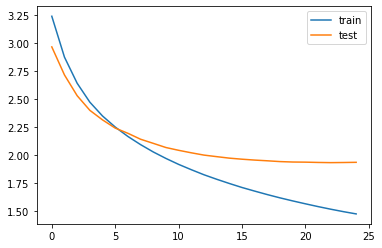

In [42]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

In [43]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [44]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


In [45]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [46]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

# Step 4. 실제 결과와 요약문 비교하기

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences

# 텍스트 데이터를 숫자 시퀀스로 변환하는 함수
def text_to_sequence(text, word_to_index):
    # '<UNK>' 토큰이 없을 경우 0을 기본값으로 사용
    unk_token = word_to_index.get('<UNK>', 0)
    return [word_to_index.get(word, unk_token) for word in text.split()]

# 원래의 요약문과 생성된 추상적 요약을 비교하는 함수
def compare_summaries(data, decoder_model, encoder_model, text_max_len, headlines_max_len, tar_word_to_index, tar_index_to_word):
    original_summaries = data['headlines']  # 원래 요약문
    generated_summaries = []  # 생성된 요약문 리스트
    
    # 각 텍스트에 대해 추상적 요약 생성
    for input_seq in data['text']:  # 'text'가 전처리된 입력 텍스트라고 가정
        # 텍스트를 숫자 시퀀스로 변환
        input_seq = text_to_sequence(input_seq, tar_word_to_index)
        
        # 입력 시퀀스를 모델에 넣기 전에 적절하게 패딩
        input_seq = pad_sequences([input_seq], maxlen=text_max_len, padding='post')
        
        # 생성된 요약
        generated_summary = decode_sequence(input_seq, decoder_model, encoder_model, tar_word_to_index, tar_index_to_word)
        generated_summaries.append(generated_summary)  # 생성된 요약 저장
    
    # 원래 요약과 생성된 요약을 DataFrame으로 비교
    comparison_df = pd.DataFrame({
        'Original Summary': original_summaries,
        'Generated Summary': generated_summaries
    })

    return comparison_df  # 비교 결과 DataFrame 반환

# 시퀀스를 디코딩하여 요약을 생성하는 함수
def decode_sequence(input_seq, decoder_model, encoder_model, tar_word_to_index, tar_index_to_word):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # <SOS>에 해당하는 토큰 생성
    start_token = np.zeros((1, 1))
    start_token[0, 0] = tar_word_to_index['<SOS>']
    
    # 추출된 상태를 이용해 디코더에 초기 입력 제공
    target_seq = start_token
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:
        # 디코더에 상태 전달 및 예측
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        
        # 예측된 토큰을 추출하고 저장
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]
        
        if sampled_token == '<EOS>' or len(decoded_sentence) > headlines_max_len:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_token
        
        # 현재 토큰을 다음 타임스텝의 디코더 입력으로 사용
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        
        # 업데이트된 상태 전달
        e_h, e_c = h, c
    
    return decoded_sentence.strip()

# 원래 사전에 <SOS>와 <EOS>가 없으면 수동으로 추가
def add_special_tokens(word_to_index, index_to_word):
    if '<SOS>' not in word_to_index:
        sos_index = len(word_to_index) + 1  # 새로운 인덱스 할당
        word_to_index['<SOS>'] = sos_index
        index_to_word[sos_index] = '<SOS>'
    
    if '<EOS>' not in word_to_index:
        eos_index = len(word_to_index) + 1  # 새로운 인덱스 할당
        word_to_index['<EOS>'] = eos_index
        index_to_word[eos_index] = '<EOS>'

# 사전에 <SOS>, <EOS> 추가
add_special_tokens(tar_word_to_index, tar_index_to_word)

# 결과를 비교하고 출력하는 함수
comparison_df = compare_summaries(data, decoder_model, encoder_model, text_max_len, headlines_max_len, tar_word_to_index, tar_index_to_word)

# 비교 결과의 상위 몇 개 출력
print(comparison_df.head())

# Step 5. Summa를 이용해서 추출적 요약해보기

In [ ]:
# 필요한 라이브러리 import
from summa.summarizer import summarize
import pandas as pd

# 텍스트 데이터를 받아 추출적 요약을 수행하는 함수
def extractive_summary(text, ratio=0.2):
    """
    주어진 텍스트에 대해 추출적 요약을 수행하는 함수.
    :param text: 원본 텍스트
    :param ratio: 요약할 텍스트의 비율 (default: 0.2)
    :return: 추출적 요약 결과
    """
    summary = summarize(text, ratio=ratio)
    return summary

# 데이터프레임에서 각 텍스트에 대해 추출적 요약을 수행하는 함수
def apply_extractive_summary_to_data(data, ratio=0.2):
    """
    데이터프레임의 'text' 열에 대해 추출적 요약을 적용하는 함수.
    :param data: 텍스트가 포함된 데이터프레임
    :param ratio: 요약 비율 (default: 0.2)
    :return: 추출적 요약이 추가된 데이터프레임
    """
    # 'text' 열을 순회하며 각 텍스트에 대해 요약 수행
    data['Extractive Summary'] = data['text'].apply(lambda x: extractive_summary(x, ratio))
    return data

summarized_data = apply_extractive_summary_to_data(data, ratio=0.2)

# 결과 확인
print(summarized_data[['text', 'Extractive Summary']].head())
